In [1]:
! pip install mordred
! pip install pubchempy
! pip install -U scikit-learn

DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\absl_py-1.4.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\astunparse-1.6.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\cachetools-5.3.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\flatbuffers-23.5.26-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package ins

DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\absl_py-1.4.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\astunparse-1.6.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\cachetools-5.3.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\flatbuffers-23.5.26-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package ins

DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\absl_py-1.4.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\astunparse-1.6.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\cachetools-5.3.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\flatbuffers-23.5.26-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package ins

In [2]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from mordred import Calculator, descriptors
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data_compound.csv")
df

,smiles,activity,type,value (nM),comment,sid,cid
0,C[C@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CC...,Active,IC50,0.0066,NaN,316936203,118159182
1,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,0.0083,NaN,316936247,118159176
2,CC(C)NC1=NC2=C(CN(CC2)C(=O)C)N=C1N3CCC(CC3)C(C...,Active,IC50,0.0085,NaN,316936221,118159272
3,CC(C)NC1=NC2=C(CN(CC2)C)N=C1N3CCC(CC3)C(=O)C4=...,Active,IC50,0.0088,NaN,316936228,118159276
4,CN(C)C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Active,IC50,0.0091,NaN,316936201,118159362
...,...,...,...,...,...,...,...
1543,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC3=CC=CC=C32,Unspecified,IC50,100000.0000,NaN,336857410,9966680
1544,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC3=CC=CC=C3C=C2,Unspecified,IC50,100000.0000,NaN,336857408,9879918
1545,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC=C2,Unspecified,IC50,100000.0000,NaN,336857473,4526747
1546,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC3=CC=CC=C32,Unspecified,IC50,100000.0000,NaN,336857410,9966680


In [4]:
import pubchempy as pcp

In [5]:
def canonical_smiles(smiles):
    mol_smiles = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mol_smiles]

    return smiles

In [6]:
CANNO_SMILES = canonical_smiles(df.smiles)
len(CANNO_SMILES)

1548

In [7]:
df['smiles'] = CANNO_SMILES
df

,smiles,activity,type,value (nM),comment,sid,cid
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,0.0066,NaN,316936203,118159182
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,0.0083,NaN,316936247,118159176
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,IC50,0.0085,NaN,316936221,118159272
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,IC50,0.0088,NaN,316936228,118159276
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,IC50,0.0091,NaN,316936201,118159362
...,...,...,...,...,...,...,...
1543,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,IC50,100000.0000,NaN,336857410,9966680
1544,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,IC50,100000.0000,NaN,336857408,9879918
1545,O=C(NC(=S)N1CCNC1=S)c1ccccc1,Unspecified,IC50,100000.0000,NaN,336857473,4526747
1546,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,IC50,100000.0000,NaN,336857410,9966680


In [8]:
smiles_list = list(df["smiles"])
smiles_list

['CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F)CC3)nc2C1',
 'CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)CN(C)CC2',
 'CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CN1CCc2nc(NC3CC3)c(N3CCC(C(F)c4ccc(F)cc4F)CC3)nc2C1',
 'CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)nc2C1',
 'CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(=O)N(C)C)C2',
 'CC1Cc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2CN1S(C)(=O)=O',
 'CC(C)Nc1nc2c(nc1N1CCC([C@H](F)c3ccc(F)cc3F)CC1)CCN(C=O)C2',
 'CC(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'COc1ccc(OC2CCN(c3nc4c(nc3NC3CCC3)CCN(C(C)=O)C4)CC2)c(F)c1',
 'CC(=O)N1CCc2nc(N3CCC(C(F)c4ccc(F)cc4F)CC3)c(NC(C)C)nc2C1',
 'CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)CCN(C)C2',
 'CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=O)N(C)C)CC2C',
 'CC(=O)N1CCc

**RDkit Descriptor**

In [9]:
smiles2 = [Chem.MolFromSmiles(i) for i in smiles_list]
mols2 = [m for m in smiles2]
len(mols2)

1548

In [10]:
alldesc = [Descriptors.CalcMolDescriptors(m) for m in mols2]
rdkit_gpr6 = pd.DataFrame(alldesc)
rdkit_gpr6

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,196,0,...,0,0,0,0,0,0,0,0,0,0
1,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,196,0,...,0,0,0,0,0,0,0,0,0,0
2,15.079211,15.079211,0.010379,-1.486341,0.715021,461.532,431.292,461.240245,178,0,...,0,0,0,0,0,0,0,0,0,0
3,14.162533,14.162533,0.087707,-0.509331,0.696577,445.970,416.738,445.204466,166,0,...,0,0,0,0,0,0,0,0,0,0
4,13.954396,13.954396,0.010776,-2.556825,0.617440,496.509,468.285,496.220987,190,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,12.443502,12.443502,0.216204,-0.216204,0.788690,315.423,302.319,315.050004,106,0,...,0,0,0,0,0,0,0,0,0,0
1544,12.273204,12.273204,0.221803,-0.221803,0.788690,315.423,302.319,315.050004,106,0,...,0,0,0,0,0,0,0,0,0,0
1545,11.829516,11.829516,0.217315,-0.217315,0.738475,265.363,254.275,265.034354,88,0,...,0,0,0,0,0,0,0,0,0,0
1546,12.443502,12.443502,0.216204,-0.216204,0.788690,315.423,302.319,315.050004,106,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#df_gpr6_compound = df.join(df_descrs)
#df_gpr6_compound

In [12]:
df_smiles = df[['smiles', 'activity']]
df_merged_smiles_rdkit = df_smiles.join(rdkit_gpr6)
df_merged_smiles_rdkit

,smiles,activity,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,...,0,0,0,0,0,0,0,0,0,0
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,...,0,0,0,0,0,0,0,0,0,0
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,15.079211,15.079211,0.010379,-1.486341,0.715021,461.532,431.292,461.240245,...,0,0,0,0,0,0,0,0,0,0
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,14.162533,14.162533,0.087707,-0.509331,0.696577,445.970,416.738,445.204466,...,0,0,0,0,0,0,0,0,0,0
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,13.954396,13.954396,0.010776,-2.556825,0.617440,496.509,468.285,496.220987,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,12.443502,12.443502,0.216204,-0.216204,0.788690,315.423,302.319,315.050004,...,0,0,0,0,0,0,0,0,0,0
1544,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,12.273204,12.273204,0.221803,-0.221803,0.788690,315.423,302.319,315.050004,...,0,0,0,0,0,0,0,0,0,0
1545,O=C(NC(=S)N1CCNC1=S)c1ccccc1,Unspecified,11.829516,11.829516,0.217315,-0.217315,0.738475,265.363,254.275,265.034354,...,0,0,0,0,0,0,0,0,0,0
1546,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,12.443502,12.443502,0.216204,-0.216204,0.788690,315.423,302.319,315.050004,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df_merged_smiles_rdkit.to_csv("rdkit_descriptors_gpr6.csv", index=False)

**Mordred Descriptors**

In [14]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=True)
    smiles3 = [Chem.MolFromSmiles(i) for i in data]
    
    df_mordred = calc.pandas(smiles3)
    return df_mordred

In [15]:
mordred_gpr6 = All_Mordred_descriptors(smiles_list)
mordred_gpr6.shape


(1548, 1613)

In [16]:
mordred_gpr6

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,27.990863,20.208094,0,0,46.356073,2.463468,4.926935,46.356073,1.287669,4.505313,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
1,27.990863,20.208094,0,0,46.356073,2.463468,4.926935,46.356073,1.287669,4.505313,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
2,25.938492,19.114455,0,0,41.715306,2.464737,4.929475,41.715306,1.2641,4.426747,...,10.479904,69.390362,461.240245,7.321274,3374,56,176.0,208.0,11.694444,7.111111
3,24.455329,18.151364,0,1,39.965051,2.458558,4.917115,39.965051,1.289195,4.367884,...,10.421954,67.098280,445.204466,7.420074,2814,52,166.0,196.0,10.583333,6.666667
4,27.393146,19.733756,0,0,44.686795,2.462679,4.925359,44.686795,1.276766,4.479689,...,10.470136,71.509172,496.220987,7.876524,4064,57,184.0,215.0,12.194444,7.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,16.389425,13.970163,0,0,27.414752,2.41071,4.815058,27.414752,1.305464,3.980899,...,9.946882,68.480833,315.050004,9.266177,938,32,110.0,130.0,6.527778,4.638889
1544,16.429865,13.664452,0,0,27.401028,2.384287,4.759565,27.401028,1.304811,3.980697,...,9.904837,68.408889,315.050004,9.266177,982,31,110.0,129.0,6.527778,4.611111
1545,12.934771,11.784329,0,0,21.715145,2.336064,4.611816,21.715145,1.277361,3.748934,...,9.490015,62.801832,265.034354,9.465513,548,22,84.0,96.0,5.805556,3.833333
1546,16.389425,13.970163,0,0,27.414752,2.41071,4.815058,27.414752,1.305464,3.980899,...,9.946882,68.480833,315.050004,9.266177,938,32,110.0,130.0,6.527778,4.638889


In [17]:
df_merged_smiles_mordred = df_smiles.join(mordred_gpr6)
df_merged_smiles_mordred

,smiles,activity,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,27.990863,20.208094,0,0,46.356073,2.463468,4.926935,46.356073,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,27.990863,20.208094,0,0,46.356073,2.463468,4.926935,46.356073,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,25.938492,19.114455,0,0,41.715306,2.464737,4.929475,41.715306,...,10.479904,69.390362,461.240245,7.321274,3374,56,176.0,208.0,11.694444,7.111111
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,24.455329,18.151364,0,1,39.965051,2.458558,4.917115,39.965051,...,10.421954,67.098280,445.204466,7.420074,2814,52,166.0,196.0,10.583333,6.666667
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,27.393146,19.733756,0,0,44.686795,2.462679,4.925359,44.686795,...,10.470136,71.509172,496.220987,7.876524,4064,57,184.0,215.0,12.194444,7.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,16.389425,13.970163,0,0,27.414752,2.41071,4.815058,27.414752,...,9.946882,68.480833,315.050004,9.266177,938,32,110.0,130.0,6.527778,4.638889
1544,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,16.429865,13.664452,0,0,27.401028,2.384287,4.759565,27.401028,...,9.904837,68.408889,315.050004,9.266177,982,31,110.0,129.0,6.527778,4.611111
1545,O=C(NC(=S)N1CCNC1=S)c1ccccc1,Unspecified,12.934771,11.784329,0,0,21.715145,2.336064,4.611816,21.715145,...,9.490015,62.801832,265.034354,9.465513,548,22,84.0,96.0,5.805556,3.833333
1546,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,16.389425,13.970163,0,0,27.414752,2.41071,4.815058,27.414752,...,9.946882,68.480833,315.050004,9.266177,938,32,110.0,130.0,6.527778,4.638889


In [18]:
df_merged_smiles_mordred.to_csv("mordred_descriptors_gpr6.csv", index=False)

**Preprocessing**

In [19]:
rdkit_gpr6.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.0,...,1548.000000,1548.000000,1548.000000,1548.0,1548.0,1548.000000,1548.0,1548.000000,1548.000000,1548.000000
mean,13.526631,13.526631,0.117090,-2.205764,0.582298,477.099918,452.054902,476.667156,177.689922,0.0,...,0.005814,0.052972,0.022610,0.0,0.0,0.005168,0.0,0.019380,0.018088,0.057494
std,1.394709,1.394709,0.146265,1.973972,0.132111,77.474852,73.853863,77.390096,31.307256,0.0,...,0.076052,0.224049,0.148704,0.0,0.0,0.071726,0.0,0.137901,0.142681,0.232858
min,4.796402,4.796402,0.000000,-5.083333,0.243006,253.308000,246.252000,252.997968,82.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
25%,13.434039,13.434039,0.024967,-5.083333,0.474032,446.450750,421.306000,445.921604,168.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
50%,13.957451,13.957451,0.056497,-0.815050,0.592339,481.569000,454.278000,481.210088,184.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
75%,14.053760,14.053760,0.161585,-0.662564,0.691333,519.459000,492.340500,519.164200,196.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
max,15.248740,15.248740,0.791107,0.716349,0.864780,656.641000,629.821000,656.248264,248.000000,0.0,...,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,2.000000,1.000000


In [20]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

In [21]:
x = scaler.fit_transform(rdkit_gpr6)
x

array([[ 0.31961795,  0.31961795, -0.69160013, ..., -0.14058039,
        -0.12681243, -0.24698317],
       [ 0.31961795,  0.31961795, -0.69160013, ..., -0.14058039,
        -0.12681243, -0.24698317],
       [ 1.11355249,  1.11355249, -0.7298068 , ..., -0.14058039,
        -0.12681243, -0.24698317],
       ...,
       [-1.21721614, -1.21721614,  0.68544846, ..., -0.14058039,
        -0.12681243, -0.24698317],
       [-0.77684935, -0.77684935,  0.67784945, ..., -0.14058039,
        -0.12681243, -0.24698317],
       [ 0.24501018,  0.24501018, -0.14712928, ..., -0.14058039,
        -0.12681243, -0.24698317]])

In [22]:
rdkit_standardized = pd.DataFrame(x, columns=rdkit_gpr6.columns)
rdkit_standardized

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.319618,0.319618,-0.691600,-0.182388,-0.285758,0.444418,0.409496,0.446629,0.585040,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1,0.319618,0.319618,-0.691600,-0.182388,-0.285758,0.444418,0.409496,0.446629,0.585040,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
2,1.113552,1.113552,-0.729807,0.364572,1.004961,-0.201007,-0.281226,-0.199404,0.009908,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
3,0.456086,0.456086,-0.200956,0.859679,0.865303,-0.401937,-0.478354,-0.406678,-0.373514,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
4,0.306805,0.306805,-0.727093,-0.177903,0.266085,0.250602,0.219831,0.252747,0.393329,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,4.048859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,-0.776849,-0.776849,0.677849,1.008222,1.562772,-2.087505,-2.028117,-2.089019,-2.290622,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1544,-0.898991,-0.898991,0.716142,1.005385,1.562772,-2.087505,-2.028117,-2.089019,-2.290622,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1545,-1.217216,-1.217216,0.685448,1.007659,1.182547,-2.733859,-2.678855,-2.735508,-2.865754,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1546,-0.776849,-0.776849,0.677849,1.008222,1.562772,-2.087505,-2.028117,-2.089019,-2.290622,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983


In [23]:
rdkit_standardized.to_csv("standardized_rdkit_gpr6.csv", index=False)

**Clustering using k-Means**

In [24]:
from sklearn.cluster import MiniBatchKMeans

In [25]:
X = rdkit_standardized
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.319618,0.319618,-0.691600,-0.182388,-0.285758,0.444418,0.409496,0.446629,0.585040,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1,0.319618,0.319618,-0.691600,-0.182388,-0.285758,0.444418,0.409496,0.446629,0.585040,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
2,1.113552,1.113552,-0.729807,0.364572,1.004961,-0.201007,-0.281226,-0.199404,0.009908,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
3,0.456086,0.456086,-0.200956,0.859679,0.865303,-0.401937,-0.478354,-0.406678,-0.373514,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
4,0.306805,0.306805,-0.727093,-0.177903,0.266085,0.250602,0.219831,0.252747,0.393329,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,4.048859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,-0.776849,-0.776849,0.677849,1.008222,1.562772,-2.087505,-2.028117,-2.089019,-2.290622,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1544,-0.898991,-0.898991,0.716142,1.005385,1.562772,-2.087505,-2.028117,-2.089019,-2.290622,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1545,-1.217216,-1.217216,0.685448,1.007659,1.182547,-2.733859,-2.678855,-2.735508,-2.865754,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1546,-0.776849,-0.776849,0.677849,1.008222,1.562772,-2.087505,-2.028117,-2.089019,-2.290622,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983


**Calculate Optimum Number of Clustering**

In [26]:
def optimise_minibatch(data, max_k):
    means = []
    inertias = []
    
    for k in range(1, max_k):
        kmeans = MiniBatchKMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('No. of Cluster')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()    
         

c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The

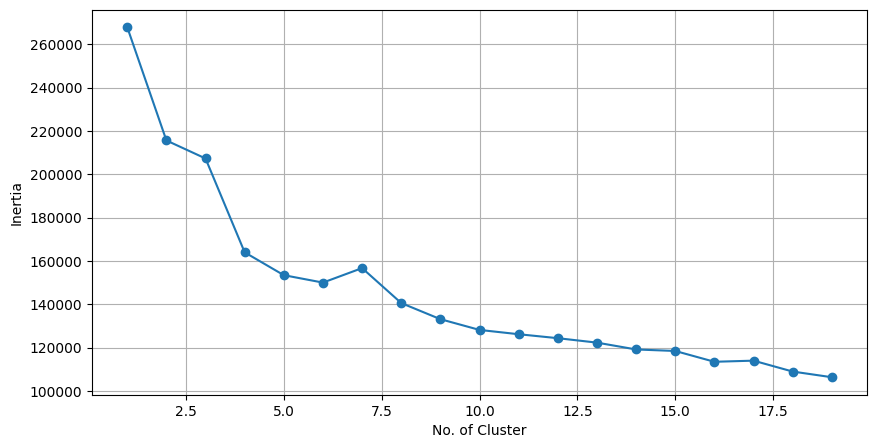

In [27]:
optimise_minibatch(x, 20)

In [28]:
kmeans2 = MiniBatchKMeans(n_clusters=3,
                         random_state=0,
                         batch_size=100,
                         max_iter=10,
                         n_init="auto")

In [29]:
kmeans2.fit(X)

MiniBatchKMeans(batch_size=100, max_iter=10, n_clusters=3, n_init='auto',
                random_state=0)

In [30]:
kmeans2.cluster_centers_

array([[-1.03153178e+00, -1.03153178e+00,  1.04079106e+00,
         9.65612666e-01,  1.27354787e+00, -2.56218038e+00,
        -2.47571979e+00, -2.56365303e+00, -2.73794722e+00,
         0.00000000e+00, -2.22710692e-01,  3.58642028e-01,
        -4.18959215e-01, -1.98572281e-01,  2.84802836e+00,
         3.04805908e+00,  3.13702500e+00,  7.98554311e-01,
         8.46572716e-01, -4.71733090e-03,  3.68553297e+00,
         1.18254665e+00,  2.96354109e+00,  2.59243122e+00,
         7.20995372e-01, -2.74515441e-01,  1.04966252e+00,
        -2.52244385e+00, -2.73197823e+00, -2.87597488e+00,
        -2.79219396e+00, -2.80937363e+00, -2.97566690e+00,
        -2.39365554e+00, -2.97727791e+00, -2.17521125e+00,
        -2.89403932e+00, -1.43492120e+00, -2.82835278e+00,
        -4.33073320e-01,  2.38095278e+00, -2.01641563e-01,
        -2.61459019e+00, -2.61404088e+00, -2.29488757e+00,
        -2.84306807e+00, -2.15807885e+00, -1.14601281e+00,
        -7.24236651e-01, -6.60800787e-01,  2.99744005e-0

**Plotting Results**

PCA

In [31]:
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.319618,0.319618,-0.691600,-0.182388,-0.285758,0.444418,0.409496,0.446629,0.585040,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1,0.319618,0.319618,-0.691600,-0.182388,-0.285758,0.444418,0.409496,0.446629,0.585040,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
2,1.113552,1.113552,-0.729807,0.364572,1.004961,-0.201007,-0.281226,-0.199404,0.009908,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
3,0.456086,0.456086,-0.200956,0.859679,0.865303,-0.401937,-0.478354,-0.406678,-0.373514,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
4,0.306805,0.306805,-0.727093,-0.177903,0.266085,0.250602,0.219831,0.252747,0.393329,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,4.048859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,-0.776849,-0.776849,0.677849,1.008222,1.562772,-2.087505,-2.028117,-2.089019,-2.290622,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1544,-0.898991,-0.898991,0.716142,1.005385,1.562772,-2.087505,-2.028117,-2.089019,-2.290622,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1545,-1.217216,-1.217216,0.685448,1.007659,1.182547,-2.733859,-2.678855,-2.735508,-2.865754,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983
1546,-0.776849,-0.776849,0.677849,1.008222,1.562772,-2.087505,-2.028117,-2.089019,-2.290622,0.0,...,-0.076472,-0.236505,-0.152095,0.0,0.0,-0.072075,0.0,-0.14058,-0.126812,-0.246983


In [32]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

In [34]:
X_pca = pca.transform(X)
X.shape

(1548, 209)

In [35]:
X_pca.shape

(1548, 3)

In [36]:
df_x_pca = pd.DataFrame(X_pca, columns= ['PCA1', 'PCA2', 'PCA3'])
df_x_pca

,PCA1,PCA2,PCA3
0,-2.464152,-5.090431,-1.455612
1,-2.464152,-5.090431,-1.455612
2,0.936271,-3.748113,-3.424775
3,3.254230,-1.332148,-3.630539
4,-1.729746,-4.737533,-2.145171
...,...,...,...
1543,15.099559,6.519352,1.198005
1544,15.114477,6.589030,1.270649
1545,18.478469,5.333684,0.306444
1546,15.099559,6.519352,1.198005


In [37]:
df_x_pca_smiles = df_smiles.join(df_x_pca)
df_x_pca_smiles

,smiles,activity,PCA1,PCA2,PCA3
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,-2.464152,-5.090431,-1.455612
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,-2.464152,-5.090431,-1.455612
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,0.936271,-3.748113,-3.424775
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,3.254230,-1.332148,-3.630539
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,-1.729746,-4.737533,-2.145171
...,...,...,...,...,...
1543,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,15.099559,6.519352,1.198005
1544,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,15.114477,6.589030,1.270649
1545,O=C(NC(=S)N1CCNC1=S)c1ccccc1,Unspecified,18.478469,5.333684,0.306444
1546,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,15.099559,6.519352,1.198005


Scatter Plot

In [38]:
! pip install plotly==5.15.0

DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\absl_py-1.4.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\astunparse-1.6.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\cachetools-5.3.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\flatbuffers-23.5.26-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package ins

In [39]:
import plotly.express as px

In [40]:
fig = px.scatter_3d(df_x_pca_smiles, x='PCA1', y='PCA2', z='PCA3', color='activity')
fig.show()